## Machine translation using Attention architecture

This notebook demonstrate the machine translation from english to hindi language using encoder-decoder architecture using attention architecture. Though the same model can be used for translating input into any other language

### Pre-requisites

- Download the data: http://www.manythings.org/anki/
- Download the word vectors: http://nlp.stanford.edu/data/glove.6B.zip

In [1]:
import os, sys
import random
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding, Bidirectional, RepeatVector
from keras.layers import Activation, Concatenate, Dot, Lambda
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
np.random.seed(1)
random.seed(1)
tf.set_random_seed(1)

In [3]:
def softmax_over_time(x):
    assert(K.ndim(x) > 2)
    e = K.exp(x- K.max(x, axis=1, keepdims=True))
    s = K.sum(e, axis=1, keepdims=True)
    return e/s

In [4]:
if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU

W0924 10:00:07.183930 140482400499520 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0924 10:00:07.185532 140482400499520 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0924 10:00:07.186332 140482400499520 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0924 10:00:07.197932 140482400499520 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf

In [5]:
# Configuration

BATCH_SIZE=64              # Batch size for training.
EPOCHS = 50                # Number of epochs to train for.
LATENT_DIM = 256           # Latent dimensionality of the encoding space.
LATENT_DIM_DECODER = 256   # Latent dimensionaliuty for the decoder
NUM_SAMPLES = 10000        # Number of samples to train on
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

In [6]:
# Where we will store the data
input_texts = []          # sentence in original language
target_texts = []         # sentence in target language
target_texts_inputs = []  # sentence in target language offset by 1

### Prepare training data

In [7]:
t = 0
for line in open('data/hin-eng/hin.txt'):
    # only keep a limited number of samples.
    t += 1
    if t > NUM_SAMPLES:
        break
        
    # input and target are separated by tab
    if '\t' not in line:
        continue
        
    # split up the input and translation
    input_text, translation = line.rstrip().split('\t')
    
    # make the target input and output using teacher forcing
    target_text = translation + ' <eos>'
    target_text_input = '<sos> ' + translation
    
    input_texts.append(input_text)
    target_texts.append(target_text)
    target_texts_inputs.append(target_text_input)
    
print("Number of samples:", len(input_texts))

Number of samples: 2808


### Tokenize the inputs (Convert the sentences (string) into integers)

In [8]:
tokenizer_inputs = Tokenizer(num_words = MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

### Word to integer mapping for input text

In [9]:
# get the word to index/integer mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found {} unique input tokens.'.format(len(word2idx_inputs)))

for x in list(word2idx_inputs)[1:10]:
    print('{}: {}'.format(x, word2idx_inputs[x]))

Found 2388 unique input tokens.
i: 2
to: 3
you: 4
is: 5
a: 6
he: 7
of: 8
in: 9
my: 10


In [10]:
# Determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)

print('max_len_input:', max_len_input)

max_len_input: 22


### Tokenize the output (Convert the sentences (string) into integers)

In [11]:
# We don't filter out special characters, otherwise <eos> and <sos> won't appear.
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
# This is an inefficient way as we are tokenizing it on the same data (target_texts and target_texts_input)
# just offset by <sos> and <eos>word2idx_outputs
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)

target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_input = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

### Word to integer mapping for output texts

In [12]:
# get the word to index mapping for output/translated language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' %len(word2idx_outputs))

for x in list(word2idx_outputs)[1:10]:
    print('{}: {}'.format(x, word2idx_outputs[x]))

Found 3138 unique output tokens.
<sos>: 2
है।: 3
में: 4
नहीं: 5
मैं: 6
वह: 7
से: 8
के: 9
मुझे: 10


In [13]:
# store number of output words for later. remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1
print('num_words_output:', num_words_output)

# determine the maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)
print ('Maximum length of target/translated text is:', max_len_target)

num_words_output: 3139
Maximum length of target/translated text is: 26


### Pad Sequences

In [14]:
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print('encoder_inputs.shape:', encoder_inputs.shape)
print('encoder_inputs[0]:', encoder_inputs[0])

encoder_inputs.shape: (2808, 22)
encoder_inputs[0]: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0 1274]


In [15]:
decoder_inputs = pad_sequences(target_sequences_input, maxlen=max_len_target, padding='post')
# 26 is the maximum length of the sentence in the translated data in the training set
print('decoder_inputs.shape:', decoder_inputs.shape)
print('decoder_inputs[0]:', decoder_inputs[0])

decoder_inputs.shape: (2808, 26)
decoder_inputs[0]: [   2 1486    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [16]:
decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')
print('decoder_targets.shape:', decoder_targets.shape)
print('decoder_targets[0]:', decoder_targets[0])

decoder_targets.shape: (2808, 26)
decoder_targets[0]: [1486    1    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


### Load pre-trained word vectors - Embeddings

In [17]:
print('Loading word vectors')
word2vec = {}
# Load word vector of 100 dimensions.
with open (os.path.join('Embeddings/glove.6B/glove.6B.%sd.txt' %EMBEDDING_DIM)) as f:
    for line in f:
        # split at spaces
        values = line.split()
        word = values[0]
        #np.asarray Converts the input to an array.
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
        
print('Found %s word vectors.' %len(word2vec))
print('Embedding dimensions: ', word2vec['the'].shape)

Loading word vectors
Found 400000 word vectors.
Embedding dimensions:  (100,)


### Prepare Embedding matrix

In [18]:
print('Filling pre-trained embeddings')
# MAX_NUM_WORDS = 20000
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not foun20000d in the embedding index will all be zero
            embedding_matrix[i] = embedding_vector

print('num_words:', num_words)
# 2389 words each of 100 dimensions
print('Shape of Embeddings matrix: ', embedding_matrix.shape)

Filling pre-trained embeddings
num_words: 2389
Shape of Embeddings matrix:  (2389, 100)


### Embedding layer

In [19]:
embedding_layer = Embedding(num_words, 
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = max_len_input,
                           #trainable=true
                           )

W0924 10:00:17.899603 140482400499520 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [20]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

# assign the values
for i, d in enumerate(decoder_targets):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

### Build encoder-decoder LSTM with Attention model

In [21]:
encoder_inputs_placeholder = Input(shape=(max_len_input, ))
x = embedding_layer(encoder_inputs_placeholder)

# Bidirectional LSTM
encoder_lstm = Bidirectional(LSTM(
    LATENT_DIM,
    return_sequences=True,
    dropout=0.5
))

encoder_outputs = encoder_lstm(x)

# setup the decoder, using [h,c] as initial state
decoder_inputs_placeholder = Input(shape=(max_len_target, ))

# this word embedding will not use pre-trained vectors although we could
decoder_embedding_layer = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs_placeholder)

W0924 10:00:18.324268 140482400499520 deprecation.py:506] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Attention

In [22]:
# Attention layer needs to be global because they will be repeated Ty times at the decoder

attn_repeat_layer = RepeatVector(max_len_input)
attn_concat_layer = Concatenate(axis=-1)
attn_dense1 = Dense(10, activation = 'tanh')
attn_dense2 = Dense(1, activation = softmax_over_time)
attn_dot = Dot(axes=1) # to perform the weighted sum of alpha[t] * h[t]

In [23]:
def one_step_attention(h, st_1):
    st_1 = attn_repeat_layer(st_1)
    
    x = attn_concat_layer([h, st_1])
    
    # Neural net first dense layer
    x = attn_dense1(x)
    
    # Neural net second layer with special softmax over time
    alphas = attn_dense2(x)
    
    context = attn_dot([alphas, h])
    
    return context

In [24]:
decoder_lstm = LSTM(
        LATENT_DIM_DECODER, 
        return_state=True,
        dropout = 0.5
    )

decoder_dense = Dense(num_words_output, activation = 'softmax')

initial_s = Input(shape=(LATENT_DIM_DECODER, ), name='s0')
initial_c = Input(shape=(LATENT_DIM_DECODER, ), name='c0')
context_last_word_concat_layer = Concatenate(axis=2)

# unlike encoder-decoder without Attention model, we don't get the output all in one step
# Instead we need to do Ty steps and in each of those steps, we need to consider all Tx h's

# s,c will be re-assigned in each iteration of the loop.
s = initial_s
c = initial_c

# Collect output in a list at first
outputs = []

for t in range (max_len_target): #Ty times
    
    # get the context using attention
    context = one_step_attention(encoder_outputs, s)
    
    # We need a different layer for each time step
    selector = Lambda(lambda x: x[:, t:t+1])
    xt = selector(decoder_inputs_x)
    
    # Combine
    decoder_lstm_input = context_last_word_concat_layer([context, xt])
    
    # pass the combined [context, last word] into LSTM along with [s, c].
    # get the new [s, c] and output
    o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s, c])
    
    # final desnse layer to get next word prediction
    decoder_outputs = decoder_dense(o)
    outputs.append(decoder_outputs)

In [25]:
# 'outputs' is now a list of length Ty
def stack_and_transpose(x):
    # x is a list of length T, each element is a batch_size * output_vocab_size tensor
    x = K.stack(x) # T * batch_size * output_vocab_size tensor
    print('x.shape:', x.shape)
    x = K.permute_dimensions(x, pattern=(1, 0, 2))  # batch_size * T * outputz_vocab_size tensor
    print('x.shape after permute_dimension:', x.shape)
    return x

# Make it a layer
stacker = Lambda(stack_and_transpose)
outputs = stacker(outputs)

# Create the model object
model = Model(
          inputs = [
               encoder_inputs_placeholder, 
               decoder_inputs_placeholder,
               initial_s,
               initial_c
          ],
          outputs = outputs)

x.shape: (26, ?, 3139)
x.shape after permute_dimension: (?, 26, 3139)
x.shape: (26, ?, 3139)
x.shape after permute_dimension: (?, 26, 3139)


### Compile the model

In [26]:
model.compile(
        optimizer = 'rmsprop',
        loss='categorical_crossentropy',
        metrics=['acc'])

W0924 10:00:26.797118 140482400499520 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



### Training Model

In [27]:
print('NUM_SAMPLES: {}, LATENT_DIM_DECODER: {}'.format(NUM_SAMPLES, LATENT_DIM_DECODER))
print('encoder_inputs.shape: {}, decoder_inputs.shape:{}'.format(encoder_inputs.shape, decoder_inputs.shape))
print('decoder_targets_one_hot.shape:', decoder_targets_one_hot.shape)
print('batch_size: {}, epochs: {}'.format(BATCH))

z = np.zeros((encoder_inputs.shape[0], LATENT_DIM_DECODER)) # initial [s, c]

history = model.fit(
    [encoder_inputs, decoder_inputs, z, z], decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2
)

NUM_SAMPLES: 10000, LATENT_DIM_DECODER: 256
encoder_inputs.shape: (2808, 22), decoder_inputs.shape:(2808, 26)


W0924 10:00:29.283782 140482400499520 deprecation.py:323] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2246 samples, validate on 562 samples
Epoch 1/50
2246/2246 [==============================] - 86s 38ms/step - loss: 2.4828 - acc: 0.7097 - val_loss: 2.9204 - val_acc: 0.5831
Epoch 2/50
2246/2246 [==============================] - 33s 15ms/step - loss: 1.7254 - acc: 0.7386 - val_loss: 2.7962 - val_acc: 0.6064
Epoch 3/50
2246/2246 [==============================] - 32s 14ms/step - loss: 1.5715 - acc: 0.7528 - val_loss: 2.7619 - val_acc: 0.6224
Epoch 4/50
2246/2246 [==============================] - 32s 14ms/step - loss: 1.4804 - acc: 0.7700 - val_loss: 2.6959 - val_acc: 0.6245
Epoch 5/50
2246/2246 [==============================] - 36s 16ms/step - loss: 1.4275 - acc: 0.7761 - val_loss: 2.7027 - val_acc: 0.6277
Epoch 6/50
2246/2246 [==============================] - 37s 16ms/step - loss: 1.3752 - acc: 0.7804 - val_loss: 2.6864 - val_acc: 0.6324
Epoch 7/50
2246/2246 [==============================] - 36s 16ms/step - loss: 1.3266 - acc: 0.7859 - val_loss: 2.6997 - val_acc: 0.6333
E

### Visualize accuracy and loss curves

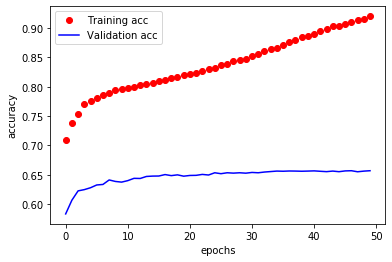

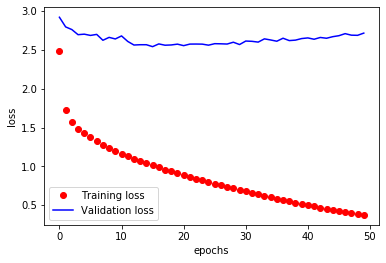

<Figure size 432x288 with 0 Axes>

In [28]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('static/acc_machine_translation_attention.png')
plt.show()
plt.clf()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.savefig('static/loss_machine_translation_attention.png')
plt.show()
plt.clf()

### Make predictions

In [32]:
# create another model that can take in the RNN state and previous word as input and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)


encoder_outputs_as_input = Input(shape=(max_len_input, LATENT_DIM * 2, ))
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

# no need to loop over attention steps this time because there is only one step
context = one_step_attention(encoder_outputs_as_input, initial_s)

# combine context with last word
decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single_x])

# lstm and final dense
o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s, initial_c])
decoder_outputs = decoder_dense(o)

# create the decoder model object
decoder_model = Model(
  inputs=[
    decoder_inputs_single,
    encoder_outputs_as_input,
    initial_s, 
    initial_c
  ],
  outputs=[decoder_outputs, s, c]
)

# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [36]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  enc_out = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))

  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']

  # [s, c] will be updated in each loop iteration
  s = np.zeros((1, LATENT_DIM_DECODER))
  c = np.zeros((1, LATENT_DIM_DECODER))

  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    
    o, s, c = decoder_model.predict([target_seq, enc_out, s, c])
 
    # output_tokens, h = decoder_model.predict(
    #     [target_seq] + states_value
    # ) # gru

    # Get next word
    idx = np.argmax(o.flatten())

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

  return ' '.join(output_sentence)


In [37]:
while True:
  # Do some test translations
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input:', input_texts[i])
  print('Predicted Translation:', translation)
  print('Actual translation:', target_texts[i])
    
  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break

-
Input: This tie doesn't go with my suit.
Predicted Translation: यह टाई मेरे सूट के साथ जचती नहीं है।
Actual translation: यह टाई मेरे सूट के साथ जचती नहीं है। <eos>
Continue? [Y/n]Y
-
Input: There is a strange man at the door.
Predicted Translation: मेज़ पर एक अजीब सा है।
Actual translation: दरवाज़े पर कोई अजीब सा इनसान है। <eos>
Continue? [Y/n]Y
-
Input: Please make yourself at home.
Predicted Translation: इसको अपना घर ही समझो।
Actual translation: इसको अपना घर ही समझो। <eos>
Continue? [Y/n]Y
-
Input: I am convinced that he did nothing wrong.
Predicted Translation: मुझे नहीं पता कि वह कैसे किया कि क्या कर रहा है।
Actual translation: मुझे पूरा विश्वास है कि उसने कोई भी ग़लत काम नहीं किया। <eos>
Continue? [Y/n]Y
-
Input: I am sorry if I disturbed you.
Predicted Translation: मैं तुम्हें कुछ ठीक से सुन नहीं पा रहा हूँ।
Actual translation: माफ़ कीजिएगा अगर मैंने आपको परेशान किया तो। <eos>
Continue? [Y/n]Y
-
Input: Who made this cake?
Predicted Translation: यह किताब किसने बनाया है?
Actual t